### Change augmentation, check score on test set

Actions
* [x] change brightness settings
* [x] create test set from the new images
* [x] compare performance for both with and without the brightness change
* [x] if not good enough: try to add preprocess function with a affine transformation in color space (9 params)
  * [x] fit a linear transformation that approximates the illumination changes between two images: conclusion: this works great. We can find the transformations for different lighting conditions. This could be a promising technique for data-augmentation. Instead of course channel-shifts, we could augment the data with simulated illumination changes. For this project I will first try and see if other preprocessing tricks will work, but this is definitely worthwhile to study further. I'd imagine that I can make some catalog of a lot of common illuminations (sunlight variation, shade, indoor, .. ) and their corresponding effects on a dataset, in terms of transformation matrices. When you have that, you can sample transformations from the distribution and use them to simulate illumination changes for augmentation. I can imaging you can also use them to create image/color embeddings, or apply that video between subsequent frames, to remove/find illumination changes in realtime.  
  * [x] instead of adding data for augmentation, try channel norm again with correct scaling back to uint8. conclusion: this approach removes color if pixels are roughly on a line, in case of a green card, it was normalized to grayscale, not really what we need here
  * [x] try pca on the colorspace to remove the noise. conclusion: in colorspace we have just three features, this means that we have limited margin for noise reduction. It is almost all or nothing. After a transform we end up with a single line of projected pixels. This is fine actually, we might use that to remove artifacts / noise
  * [x] use k-means clustering just find colour-clusters. conclusion: clustering works great for set cards, because we know what to expect. A large white cluster, a cluster with the main colour, and perhaps a cluster with low-intensity values from the background
  * [x] check performance on testset that is color corrected, conclusion: 
    * [x] 4 clusters - train_score: 1.0000, val_score: 1.0000, test_score: 0.9914, test_score (corrected): 0.8879
    * [x] 10 clusters - train_score: 1.0000, val_score: 1.0000, test_score: 0.9914, test_score (corrected): 0.9569
    * conclusion: performance with correction is lower. Perhaps by reducing the dimensions, removes some of the features the model depends on. 
  * Retrain trainingset with color correction:
    * [x] Train_score: 0.9578, val_score: 0.9383, test_score: 0.9914
    * [x] conclusion: color information for some cards is very distorted, we don't get to full convergence, test_score is highest, so I guess we are overfitting to testset here!
 * Try to correct the color, without reducing the dimensionality of the image and see what performance is on the testset (or with retraining)
    * Train_score: 1.0000, val_score: 1.0000, test_score: 0.9914, test_score (corrected): 0.9914
 * [ ] define 9 ranges (close to diagonal), and do hyper param search and compare performance on ~3000 image
    
Results data augmentations
  * [x] 8100 - no brightness_range: train: 1.0, val: 1.0, test: 0.9397
  * [x] 8100 - brightness_range 0.5 - 1.0, train: 1.0, val: 1.0, test: 0.9569
  * [x] 8100 - brightness_range 0.2 - 1.0, train: 1.0, val: 0.9753, test: 0.9741
  * [x] 8100 - brightness_range 0.5 - 1.0 + zca_whitening: 0.9569
  * [x] 8100 - brightness_range 0.5 - 1.0 + fill_model 'constant': train: 1.0, val: 1.0, test: 0.9914
  * [x] 16200 - brightness_range 0.5 - 1.0 + fill_model 'constant': train: 1.0, val: 1.0, test: 0.9914
  * [x] 8100 - brightness_range 0.5 - 1.0 + fill_model 'constant' + 'width_shift_range' 0.3: train_score: 1.0000, val_score: 0.7901, test_score: 0.6552
  * [x] 8100 - brightness_range 0.5 - 1.0 + fill_model 'constant' + 'width_shift_range' 0.1: train_score: 1.0000, val_score: 0.9753, test_score: 0.9310
  * [x] 8100 - brightness_range 0.5 - 1.0 + fill_model 'constant' + 'width_shift_range' 0.05: train_score: 1.000, val_score: 1., test_score: 0.9569

### Magics

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Salomon Tetelepta' -d -t -v -p tensorflow,numpy,pandas,matplotlib -g

Salomon Tetelepta 2019-10-05 08:09:57 

CPython 3.7.4
IPython 7.7.0

tensorflow 1.14.0
numpy 1.16.4
pandas 0.25.0
matplotlib 3.1.1
Git hash: 51c82ec9c1bc58508bc4355d528a4beb02bd6c43


### Imports

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import cv2

import pickle
import random

from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt

# tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.models import save_model, load_model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.compat.v1 import set_random_seed

## import DCNN models
from tensorflow.keras.applications import ResNet50, MobileNet, MobileNetV2

## import preprocessing functions for each model
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_input_mobile_net
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobile_net_v2

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# scipy
from scipy.optimize import minimize

### Settings

In [3]:
# get project path, and flag if script runs in a file
project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"
model_path = project_path / "models"
results_csv_path = output_path / 'results.csv'

# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import custom packages
from set_cardgame.dataset import *
from set_cardgame.identify import *   
from set_cardgame.utils import *
from set_cardgame.colour_augmentation import *

# make results repeatable
seed = 42
random.seed(seed)  # python built-in pseudo-random generator
np.random.seed(seed)  # numpy pseudo-random generator
set_random_seed(seed)  # tensorflow pseudo-random generator

### Load data

In [4]:
nr_images = 810

# load training and validation data
X_train, y_train, X_val, y_val = load_dataset(nr_images=nr_images)

# load test data
df_meta = load_metadata()
flow_params = {
    'target_size': (96, 128),
    'batch_size': 116,
    'shuffle': False,
    'seed': 42 
}
directory_iterator = ImageDataGenerator().flow_from_directory(dataset_path / "test", **flow_params)
X_test, y_test_ind = next(directory_iterator)
y_test = get_labels_from_iterator(directory_iterator, y_test_ind)
y_labels = get_feature_labels(df_meta, y_test)

# save nr samples for convience
m_train = X_train.shape[0]
m_val = X_val.shape[0]
m_test = X_test.shape[0]

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("X_test.shape:", X_test.shape)
print("Number of training samples (m_train):", m_train)
print("Number of validation samples (m_val):", m_val)
print("Number of test samples (m_test):", m_test)

{'shear_range': 0.4, 'zoom_range': 0.4, 'rotation_range': 45, 'horizontal_flip': True, 'vertical_flip': True, 'brightness_range': (0.5, 1.0), 'fill_mode': 'constant'}
Found 243 images belonging to 81 classes.
Found 81 images belonging to 81 classes.
Found 116 images belonging to 42 classes.
X_train.shape: (810, 96, 128, 3)
X_val.shape: (81, 96, 128, 3)
X_test.shape: (116, 96, 128, 3)
Number of training samples (m_train): 810
Number of validation samples (m_val): 81
Number of test samples (m_test): 116


#### Using DCNN features

In [5]:
# load intermediate DCNN (ResNet50), outputs at best performing layer (stage 3, blockd, first conv layer)
dcnn_model_name = "resnet50-res3d_branch2a.h5"
intermediate_model = load_model(
    model_path / dcnn_model_name,
    custom_objects=None, 
    compile=True
)

W1005 08:10:18.801810 4665972160 deprecation.py:506] From /Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1005 08:10:18.803173 4665972160 deprecation.py:506] From /Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1005 08:10:18.805424 4665972160 deprecation.py:506] From /Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:

In [6]:
# X_test_color_corrected = batch_correct_color(X_test, n_clusters=10)
X_test_color_corrected = batch_correct_color1(X_test, n_clusters=10)

# apply preprocessing for the specified model
preprocess_input_function = preprocess_input_resnet50
X_train_preprocessed = preprocess_input_function(X_train.copy())
X_val_preprocessed = preprocess_input_function(X_val.copy())
X_test_preprocessed = preprocess_input_function(X_test.copy())

X_test_preprocessed_color_corrected = preprocess_input_function(X_test_color_corrected.copy())

# generate image embeddings
X_train_embeddings = intermediate_model.predict(X_train_preprocessed)
X_val_embeddings = intermediate_model.predict(X_val_preprocessed)
X_test_embeddings = intermediate_model.predict(X_test_preprocessed)
X_test_embeddings_color_corrected = intermediate_model.predict(X_test_preprocessed_color_corrected)

# reshape embeddings to 2D
X_train_embeddings_2d = X_train_embeddings.reshape(m_train, -1)
X_val_embeddings_2d = X_val_embeddings.reshape(m_val, -1)
X_test_embeddings_2d = X_test_embeddings.reshape(m_test, -1)
X_test_embeddings_color_corrected_2d = X_test_embeddings_color_corrected.reshape(m_test, -1)

### Evaluate best model

#### Results for 8100-image dataset

In [7]:
nr_images = 8100

# linear_classifier_model_name = f"clf-lr-res3d_branch2a_{nr_images}.pkl"
linear_classifier_model_name = f"clf-lr-res3d_branch2a_{nr_images}_brightness.pkl"
with open(model_path / linear_classifier_model_name, 'rb') as handle:
    best_model = pickle.load(handle)
    
# evaluate model
train_score = best_model.score(X_train_embeddings_2d, y_train)
val_score = best_model.score(X_val_embeddings_2d, y_val)
test_score = best_model.score(X_test_embeddings_2d, y_test)
test_score_color_corrected = best_model.score(X_test_embeddings_color_corrected_2d, y_test)
print(f"Train_score: {train_score:.4f}, val_score: {val_score:.4f}, test_score: {test_score:.4f}, test_score (corrected): {test_score_color_corrected:.4f}")

Train_score: 1.0000, val_score: 1.0000, test_score: 0.9914, test_score (corrected): 0.9914


### Idea: data augmentation with affine transformations

* The idea is to augment the dataset by applying affine transformations to simulate different lighting conditions
* The question then is, what are realistic transformations? To find those, we will approximate the transformations using least square approximation. 
  * For an image X, and an image X' of the same card under different lighting conditions, the goal is to find transformation T, so that X' - T * X is minimized
* By collecting transformations for different images, we might find a distribution of transformations that relate to different lighting conditions. 
* We might have a setup where we take images of each card and the lighting conditions in a controlled setting, ie:
  * outdoor sunny / shade / morning / afternoon / evening
  * indoor LED / candle / lightbulb / shade
* Perhaps we find clusters of transformations that we can used to simulate a lighting condition
* We might use interpolation or sampling to come up with similar transformations, or even flip the values for the channels, to simulate different colours.
* The end result would be a preprocessing function that will augment an image, which we can use as an additional augmentation step

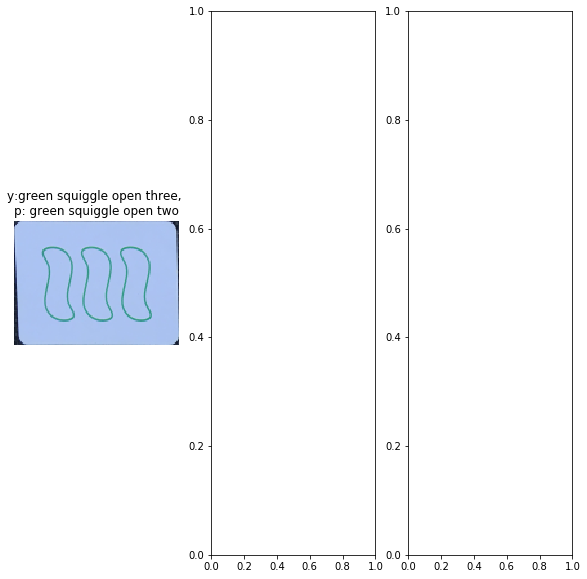

In [8]:
def plot_errors(X, y, p, df_meta):
    nr_errors = len(np.where(y != p)[0])
    ncols = 3
    nrows = 1+(nr_errors // ncols)
    fix, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10*nrows))
    i = 0
    for ind in np.arange(len(p)):
        if y[ind] != p[ind]:
            r = i // ncols
            c = i % ncols
            y_label = get_card_data(df_meta, y[ind])['label']
            p_label = get_card_data(df_meta, p[ind])['label']

            if nr_errors > 1:
                ax = axs[r, c]
            else:
                ax = axs[0]
            ax.set_title(f"y:{y_label}, \np: {p_label}")
            ax.imshow(X[ind]/255)
            ax.axis('off')
            i += 1
            
p_test = best_model.predict(X_test_embeddings_2d)
df_meta = load_metadata()
plot_errors(X_test, y_test, p_test, df_meta)

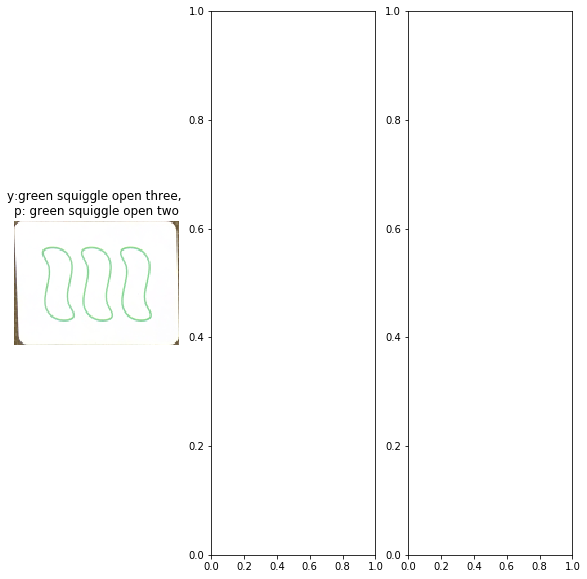

In [998]:
p_test = best_model.predict(X_test_embeddings_color_corrected_2d)
df_meta = load_metadata()
plot_errors(X_test_color_corrected, y_test, p_test, df_meta)

In [1000]:
def affine_transformation_rgb(img, transformation_matrix):
    # reshape to 2d
    img_flat = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    
    # apply transformation
    img_flat_new = np.dot(img_flat, transformation_matrix).reshape(img.shape)
    
    # scale back to uint8
    img_affine = cv2.convertScaleAbs(img_flat_new)

    return img_affine

def batch_diagonal(img2d, beta=(1, 1, 1)):
    img = img2d.reshape(96, 128, 3)
    
    transformation_matrix = np.array([[beta[0], 0, 0], [0, beta[1], 0], [0, 0, beta[2]]])

    return affine_transformation_rgb(img, transformation_matrix)

def plot_histogram(img):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    axs[0].imshow(img)
    axs[1].set_title("red channel")
    axs[1].hist(img[:,:,0].reshape(img.shape[0]*img.shape[1]))
    axs[2].set_title("green channel")
    axs[2].hist(img[:,:,1].reshape(img.shape[0]*img.shape[1]))
    axs[3].set_title("blue channel")
    axs[3].hist(img[:,:,2].reshape(img.shape[0]*img.shape[1]))

def plot_scatter(img, label="", suptitle=""):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    fig.suptitle(suptitle)
    for i, colors in enumerate([("red", "green"), ("red", "blue"), ("blue", "green")]):
        color_channels = {'red': 0, 'green': 1, 'blue': 2}
        channels = (color_channels[colors[0]], color_channels[colors[1]])
        x = img[:,:,channels[0]].reshape(img.shape[0]*img.shape[1])
        y = img[:,:,channels[1]].reshape(img.shape[0]*img.shape[1])

        axs[0].set_title(label)
        axs[0].imshow(img/255)        
        axs[i+1].set_title(f"{colors[0]} vs {colors[1]}")
        axs[i+1].set_xlim(0, 255)
        axs[i+1].set_ylim(0, 255)    
        axs[i+1].set_xlabel(colors[0])
        axs[i+1].set_ylabel(colors[1])
        axs[i+1].plot(x, y, linestyle="None", marker=".", color="k", markersize=2)

In [1001]:
nr_images = 8100

# linear_classifier_model_name = f"clf-lr-res3d_branch2a_{nr_images}.pkl"
linear_classifier_model_name = f"clf-lr-res3d_branch2a_{nr_images}_brightness.pkl"
with open(model_path / linear_classifier_model_name, 'rb') as handle:
    best_model = pickle.load(handle)

In [1003]:
# beta_list = [
#     (1, 1, 1),
#     (0.95, 0.95, 0.95),
#     (0.90, 0.90, 0.90),
#     (0.95, 1, 1),
#     (0.90, 1, 1),
#     (1, 0.95, 1),
#     (1, 0.9, 1),
#     (1, 1, 0.95),
#     (1, 1, 0.9),       
# ]
# fig, axs = plt.subplots(nrows=len(beta_list), ncols=2, figsize=(10, 20))
# for i, beta in enumerate(beta_list):
#     # apply color transform on validation set to create new set
#     X_val1 = np.apply_along_axis(batch_diagonal, 1, X_val.reshape(m_val, -1), beta=beta)   
#     X_val1_preprocessed = preprocess_input_function(X_val1.copy())
#     X_val1_embeddings = intermediate_model.predict(X_val1_preprocessed)
#     X_val1_embeddings_2d = X_val1_embeddings.reshape(m_val, -1)
    
#     val_score = best_model.score(X_val_embeddings_2d, y_val)
#     val1_score = best_model.score(X_val1_embeddings_2d, y_val)
#     print("beta: ", beta)
#     print(f"val_score: {val_score:.4f}, val1_score: {val1_score:.4f}")

#     axs[i, 0].imshow(X_val[0]/255)
#     axs[i, 0].axis('off')
    
#     axs[i, 1].imshow(X_val1[0])
#     axs[i, 1].axis('off')
    
#     plot_scatter(X_val1[0])
    
# plt.show()

### Fit transformation

To find out what are realistic lightning changes, we will take images of a card for different lightning conditions (X and Xi) and we use least square optimization to find an affine transformation T that relates those images 
X' = TX

In [1004]:
def objective(t, img1, img2):
    t = t.reshape(3, 3)
    return np.sum(np.abs(img2 - np.dot(img1, t)))

def find_transformation(img1, img2):
    # initial guess
    x0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    
    # minimize objective
    sol = minimize(objective, x0, method='SLSQP', args=(img1, img2))
    
    # return solution as 3x3 matrix
    #return np.round(sol.x, 2).reshape(3, 3)
    return sol.x.reshape(3, 3)

In [1005]:
# Create (unknown) transformation matrix
T_u = np.array([[0.8, 0, 0], [0., 1, 0], [0, 0, 1]])

# original image
img = X_val[0]

# apply affine transformation to simulate lighting change
img1 = affine_transformation_rgb(img, T_u)

# approximate transformation between the two images
T_approx = find_transformation(img, img1)

# apply transformation on original image
img_approx = affine_transformation_rgb(img, T_approx)

In [1007]:
# output = []
# for card_id in np.arange(81):
#     datasets = ["train", "test"]

#     for dataset in datasets:
#         image_path = project_path / "src" / "set_cardgame" / "data" / "128x96" / dataset / f"{card_id}"
#         try:
#             i = 0
#             for img_name in os.listdir(image_path):
#                 ext = img_name.split('.')[-1].lower()

#                 if ext.lower() in ['jpg', 'png']:
#                     #img = cv2.imread(str(image_path / img_name))
#                     #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#                     output.append({'card_id': card_id, 'dataset': dataset, 'variant': i, 'img': str(image_path / img_name)})
#                     i += 1
#         except Exception as e:
#             pass
#             #print("warning: ", e)

In [1008]:
# card_id = 5
# cond_card_id = (df_test['card_id']==card_id)
# cond_train = (df_test['dataset']=="train")
# cond_test = (df_test['dataset']=="test")
# df_test[cond_card_id]

# img_train = []
# for i, row in df_test[cond_card_id & cond_train].iterrows():
#     print(row['img'])
#     img = cv2.imread(row['img'])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_train.append(img)
    
# img_test = []
# for i, row in df_test[cond_card_id & cond_test].iterrows():
#     img = cv2.imread(row['img'])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_test.append(img)

In [429]:
dataset_path = Path("/Users/salomon/work/fink-projects/setdetection/notebooks/../src/set_cardgame/data/128x96")

def get_image(dataset_path, dataset, card_id):
    image_path = dataset_path / dataset / f"{card_id}"
    filename = os.listdir(dataset_path / dataset / f"{card_id}")[0]
    img = cv2.imread(str(image_path / filename))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [1010]:
dataset1 = "train"
dataset2 = "validation"
plot = False
transformation_list = []
for card_id in tqdm(np.arange(81)):
    try:
        img1 = get_image(dataset_path, dataset1, card_id)
        img2 = get_image(dataset_path, dataset2, card_id)

        # approximate transformation between the two images
        T_approx = find_transformation(img1, img2)
        transformation_list.append(T_approx)
        img_approx = affine_transformation_rgb(img1, T_approx)
        
        if plot == True:
            fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
            axs[0].set_title(f"card: {card_id}, dataset: train")
            axs[0].imshow(img1)
            axs[1].set_title(f"card: {card_id}, dataset: train")
            axs[1].imshow(img2)
            axs[2].set_title(f"card: {card_id}, approximated")
            axs[2].imshow(img_approx)
            plt.show()
    except Exception as e:
        pass
    
color_cards = {
    'train': {
        'red': transformation_list[0:27],
        'green': transformation_list[27:54],
        'purple': transformation_list[54:81]
    },
    'validation': {
        'red': transformation_list[0:27],
        'green': transformation_list[27:54],
        'purple': transformation_list[54:81]
    },
    'test': {
        'red': transformation_list[0:14],
        'green': transformation_list[14:25],
        'purple': transformation_list[25:42]
    }
}



  0%|          | 0/81 [00:00<?, ?it/s]

  1%|          | 1/81 [00:00<01:10,  1.14it/s]

  2%|▏         | 2/81 [00:01<01:05,  1.20it/s]

  4%|▎         | 3/81 [00:02<01:02,  1.25it/s]

  5%|▍         | 4/81 [00:03<01:02,  1.22it/s]

  6%|▌         | 5/81 [00:03<01:00,  1.25it/s]

  7%|▋         | 6/81 [00:04<00:58,  1.28it/s]

  9%|▊         | 7/81 [00:05<00:58,  1.26it/s]

 10%|▉         | 8/81 [00:06<00:56,  1.30it/s]

 11%|█         | 9/81 [00:06<00:54,  1.31it/s]

 12%|█▏        | 10/81 [00:07<00:48,  1.46it/s]

 14%|█▎        | 11/81 [00:08<00:48,  1.44it/s]

 15%|█▍        | 12/81 [00:08<00:46,  1.47it/s]

 16%|█▌        | 13/81 [00:09<00:45,  1.50it/s]

 17%|█▋        | 14/81 [00:10<00:42,  1.57it/s]

 19%|█▊        | 15/81 [00:10<00:41,  1.61it/s]

 20%|█▉        | 16/81 [00:11<00:42,  1.53it/s]

 21%|██        | 17/81 [00:12<00:44,  1.43it/s]

 22%|██▏       | 18/81 [00:12<00:45,  1.38it/s]

 23%|██▎       | 19/81 [00:13<00:43,  1.44it/s]

 25%|██▍       | 20/81 [00:14<00:41,

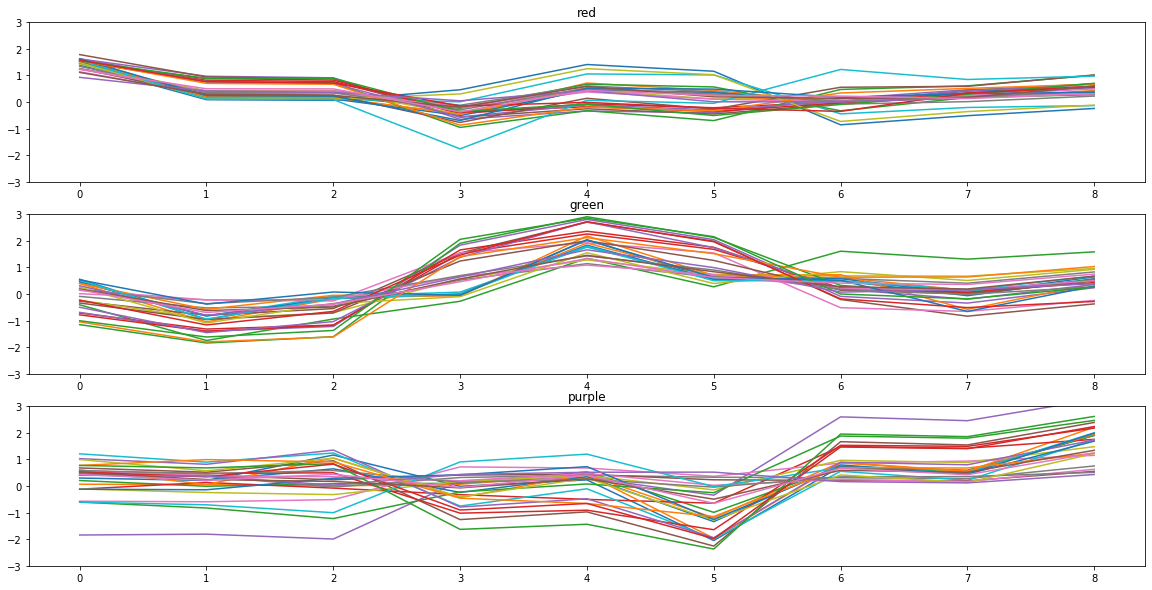

In [430]:
fix, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
for tt in color_cards[dataset2]['red']:
    axs[0].set_title("red")
    axs[0].plot(np.ravel(tt))
    axs[0].set_ylim(-3, 3)
for tt in color_cards[dataset2]['green']:
    axs[1].set_title("green")
    axs[1].plot(np.ravel(tt))
    axs[1].set_ylim(-3, 3)    
for tt in color_cards[dataset2]['purple']:
    axs[2].set_title("purple")
    axs[2].plot(np.ravel(tt))
    axs[2].set_ylim(-3, 3)
plt.savefig(output_path / f"transformations_{dataset1}_{dataset2}_rgb.png", bbox_inches='tight')
plt.show()

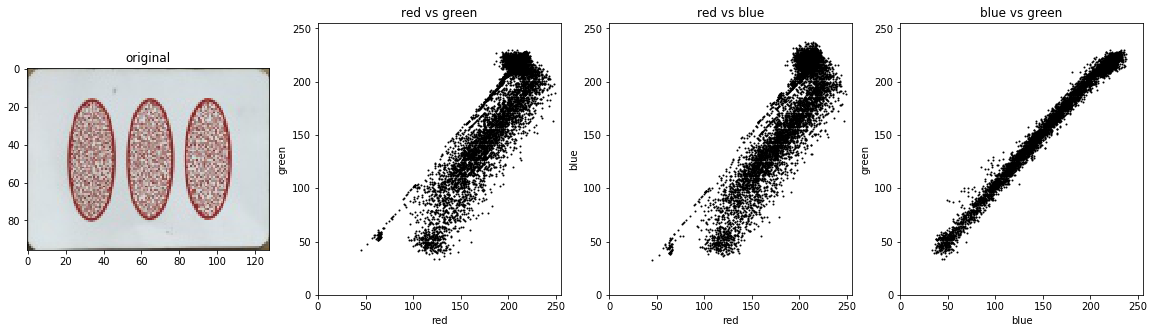

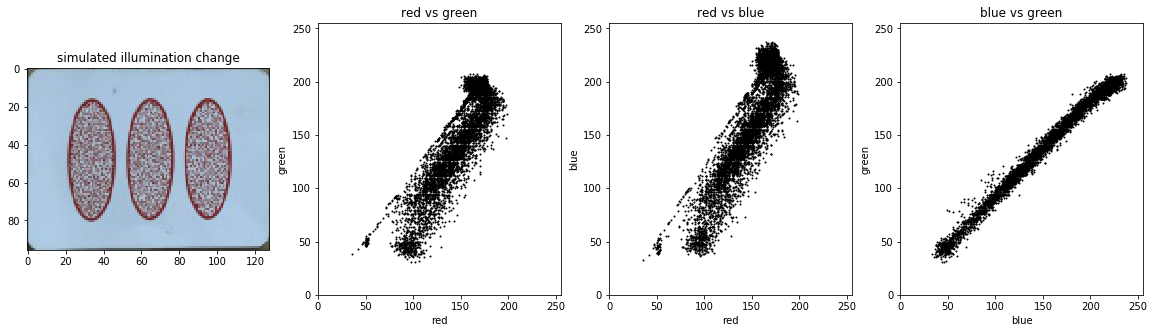

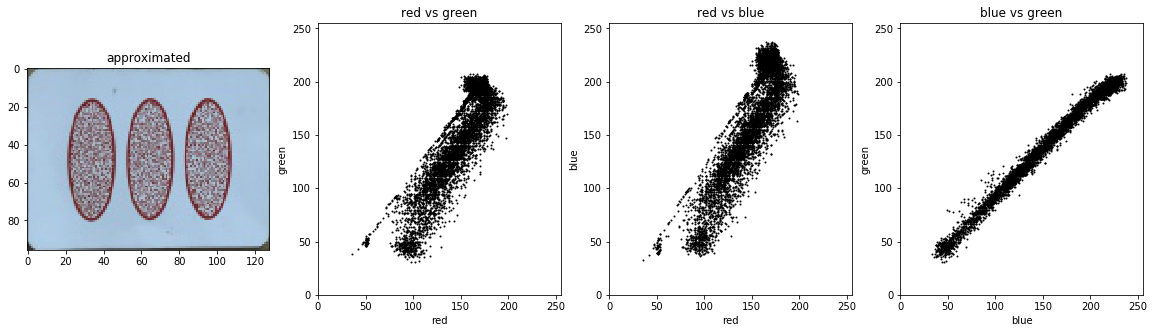

In [439]:
dataset_path = Path("/Users/salomon/work/fink-projects/setdetection/notebooks/../src/set_cardgame/data/128x96")
dataset = "train"
card_id = "5"

# read image
img = get_image(dataset_path, dataset, card_id)

# simulate change in illumination
T = np.array([[0.8, 0, 0], [0, 0.9, 0], [0, 0, 1]])
img_simulate = affine_transformation_rgb(img, T)

# find the transformation using scipy.minimize
T_approx = find_transformation(img, img_simulate)
img_approx = affine_transformation_rgb(img, T_approx)

# scatter for different channels
plot_scatter(img, label="original")
plot_scatter(img_simulate, label="simulated illumination change")
plot_scatter(img_approx, label="approximated")

[[ 1.53718991  0.21155671  0.18596069]
 [ 0.45110874  0.88065605  0.82893798]
 [-0.95684072 -0.05052644  0.01349033]]


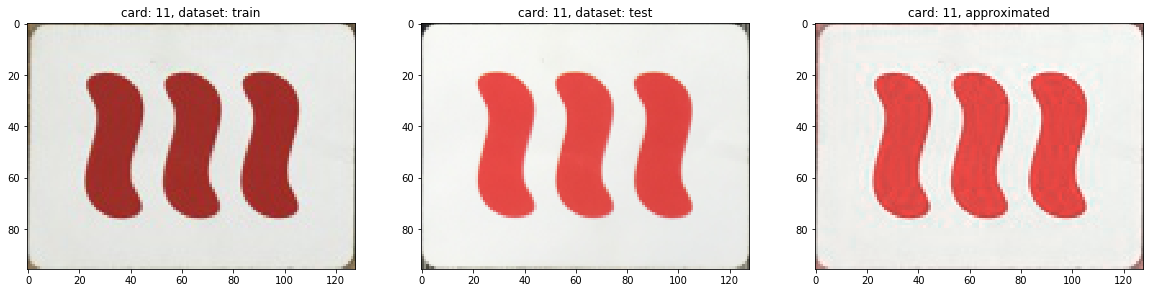

In [442]:
card_id = 11
img1 = get_image(dataset_path, "train", card_id)
img2 = get_image(dataset_path, "test", card_id)

# approximate transformation between the two images
T_approx = find_transformation(img1, img2)
print(T_approx)
img_approx = affine_transformation_rgb(img1, T_approx)

fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].set_title(f"card: {card_id}, dataset: train")
axs[0].imshow(img1)
axs[1].set_title(f"card: {card_id}, dataset: test")
axs[1].imshow(img2)
axs[2].set_title(f"card: {card_id}, approximated")
axs[2].imshow(img_approx)
plt.show()

### try normalizing per channel

In [755]:
def apply_channel_norm(img):
    img_norm = img.copy()
    img_norm[:,:,0] = cv2.normalize(img[:,:,0], None, 0, 255, cv2.NORM_MINMAX)
    img_norm[:,:,1] = cv2.normalize(img[:,:,1], None, 0, 255, cv2.NORM_MINMAX)
    img_norm[:,:,2] = cv2.normalize(img[:,:,2], None, 0, 255, cv2.NORM_MINMAX)
    
    # scale back to uint8
    img_norm = cv2.convertScaleAbs(img_norm)
    return img_norm

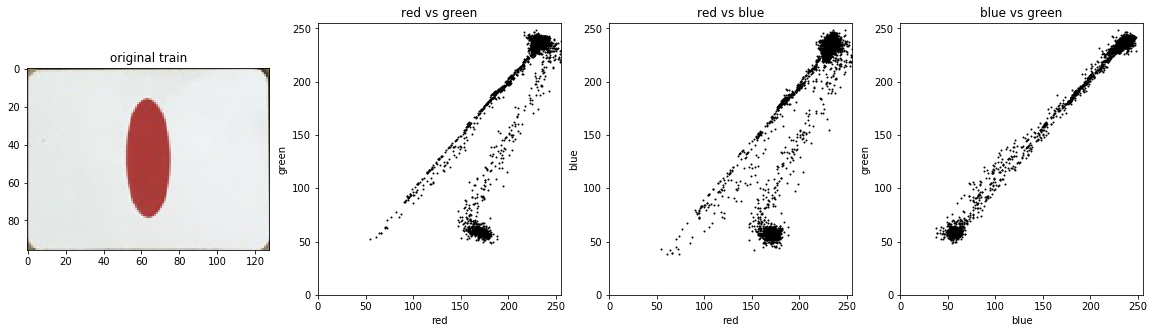

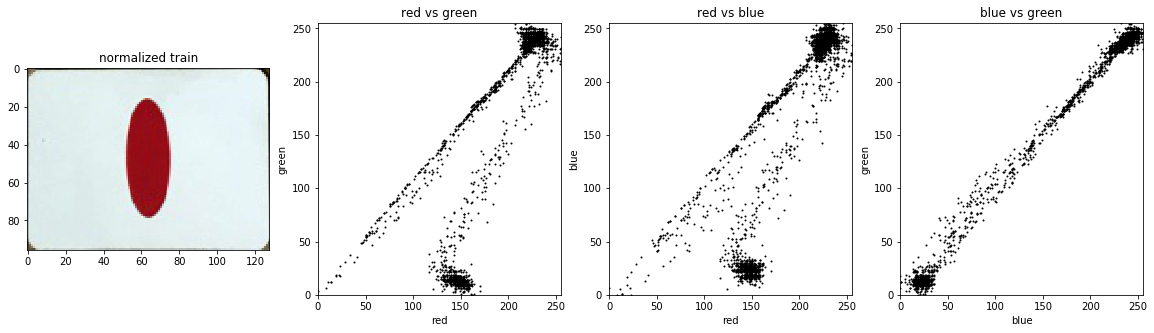

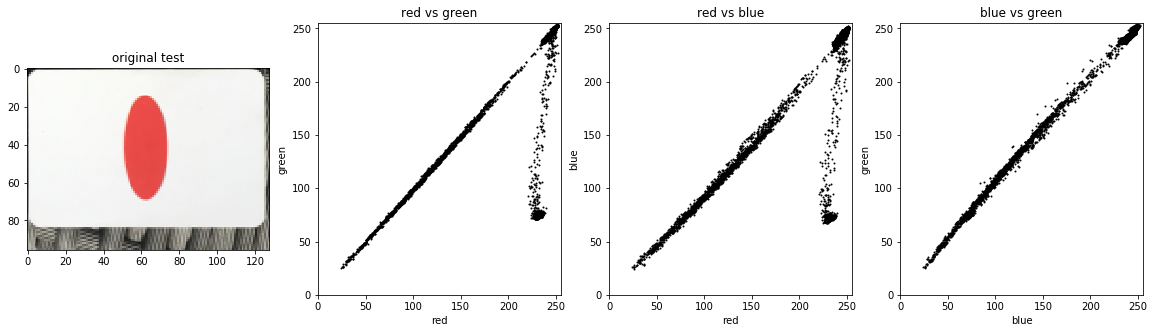

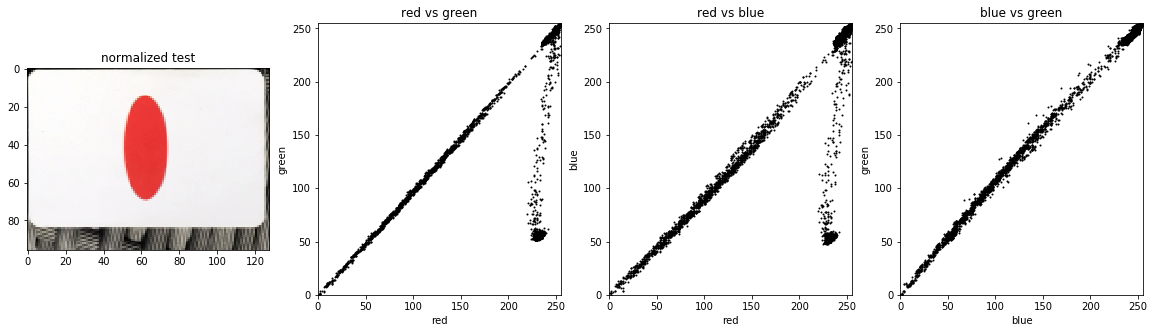

In [732]:
card_id = 0
img1 = get_image(dataset_path, "train", card_id)
img2 = get_image(dataset_path, "test", card_id)

img1_norm = apply_channel_norm(img1)
img2_norm = apply_channel_norm(img2)

plot_scatter(img1, label="original train")
plot_scatter(img1_norm, label="normalized train")
plot_scatter(img2, label="original test")
plot_scatter(img2_norm, label="normalized test")

### Try PCA on color space

In [615]:
def apply_pca(img, var_explained=0.95):
    pca = PCA(var_explained)
    img_2d = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    components = pca.fit_transform(img_2d)
    img_pca_2d = pca.inverse_transform(components)
    return img_pca_2d.reshape(img.shape)

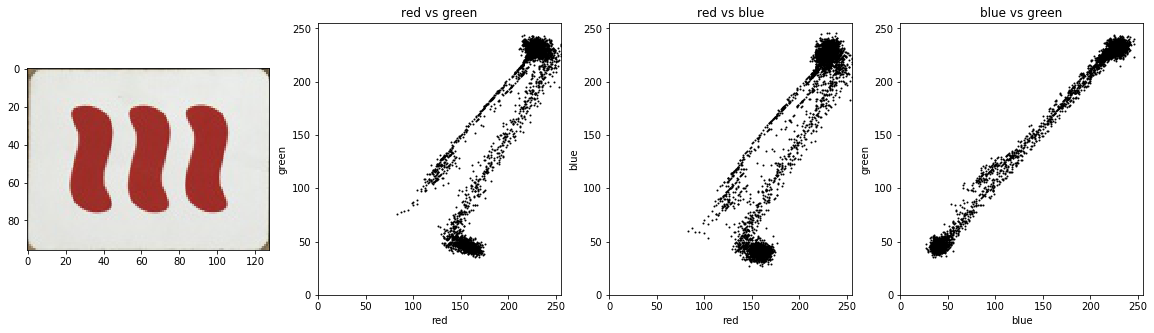

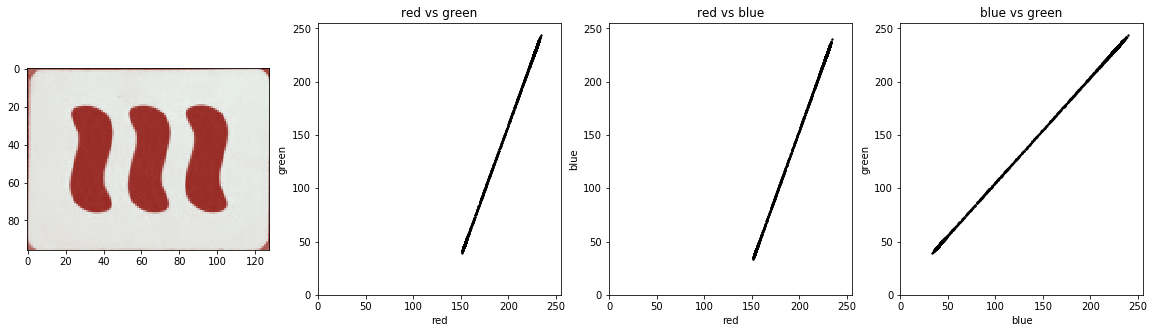

In [595]:
card_id = 11
img1 = get_image(dataset_path, "train", card_id)
img2 = apply_pca(img1)

plot_scatter(img1)
plot_scatter(img2)

### Try kmeans clustering

In [750]:
def plot_scatter_centroids(img, label="", suptitle="", centroids=None):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    fig.suptitle(suptitle)
    for i, colors in enumerate([("red", "green"), ("red", "blue"), ("blue", "green")]):
        color_channels = {'red': 0, 'green': 1, 'blue': 2}
        channels = (color_channels[colors[0]], color_channels[colors[1]])
        x = img[:,:,channels[0]].reshape(img.shape[0]*img.shape[1])
        y = img[:,:,channels[1]].reshape(img.shape[0]*img.shape[1])

        axs[0].set_title(label)
        axs[0].imshow(img/255)        
        axs[i+1].set_title(f"{colors[0]} vs {colors[1]}")
        axs[i+1].set_xlim(0, 255)
        axs[i+1].set_ylim(0, 255)    
        axs[i+1].set_xlabel(colors[0])
        axs[i+1].set_ylabel(colors[1])
        axs[i+1].plot(x, y, linestyle="None", marker=".", color="skyblue", markersize=10)
        
    for centroid in centroids:
        axs[1].plot(centroid[0], centroid[1], marker=".", color="red", markersize="20", alpha=0.3)
        axs[2].plot(centroid[0], centroid[2], marker=".", color="red", markersize="20", alpha=0.3)
        axs[3].plot(centroid[2], centroid[1], marker=".", color="red", markersize="20", alpha=0.3)

In [751]:
def reduce_with_clusters(img, n_clusters=10):
    # number of clusters
    kmeans = KMeans(n_clusters=n_clusters)

    # flatten image
    img_2d = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    
    # fit image
    kmeans = kmeans.fit(img_2)

    # centroid values
    centroids = kmeans.cluster_centers_

    # move pixel values to nearest cluster
    distances = []
    for centroid in centroids:
        distances.append(np.linalg.norm(img_2d - centroid, axis=1))
    distances = np.array(distances).T
    closed_centroid = np.argmin(distances, axis=1)
    img_reduced = centroids[closed_centroid]
    return img_reduced.reshape(96,128,3), centroids

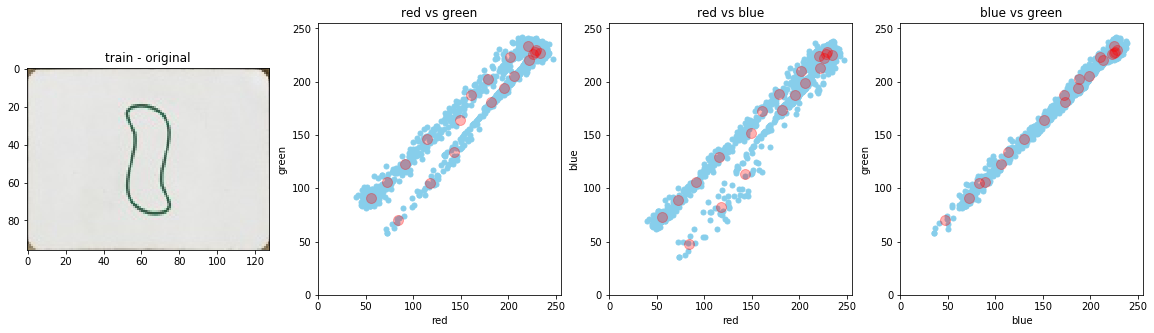

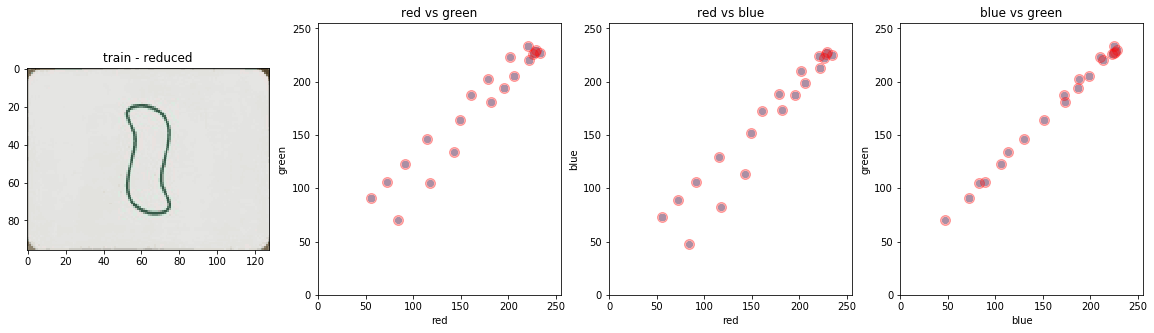

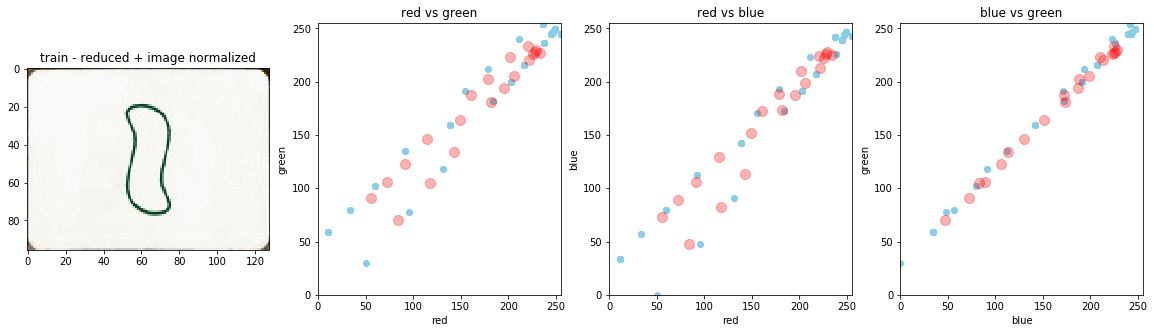

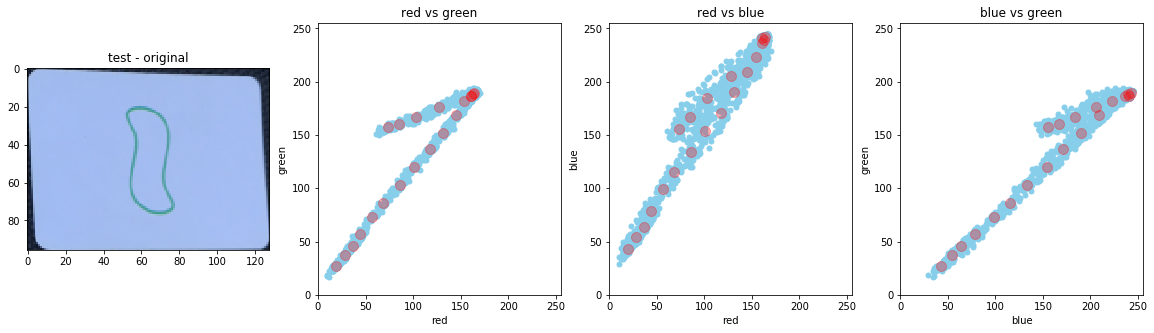

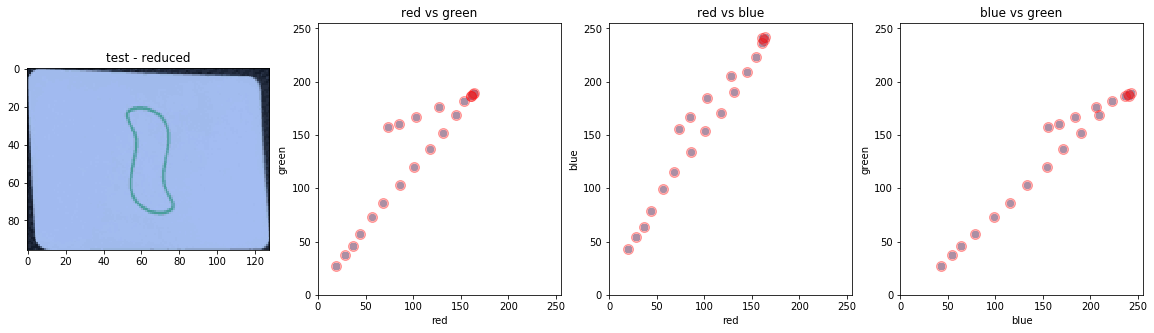

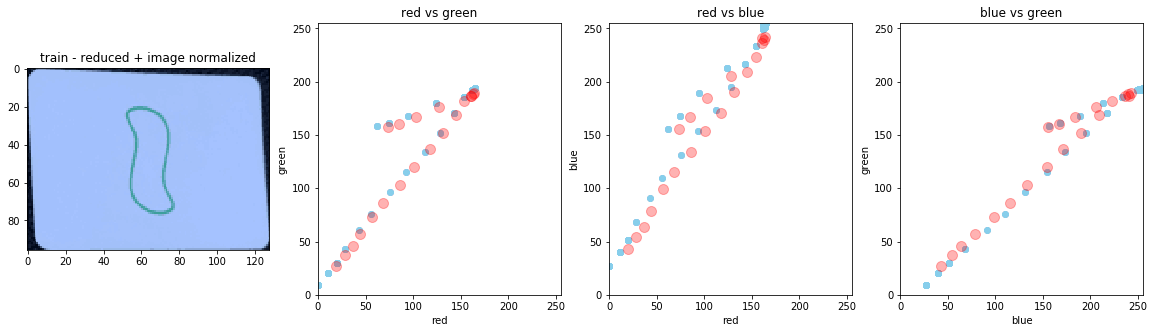

In [758]:
card_id = 42
img1 = get_image(dataset_path, "train", card_id)
img2 = get_image(dataset_path, "test", card_id)

img1_reduced, centroids1 = reduce_with_clusters(img1, n_clusters=20)
img2_reduced, centroids2 = reduce_with_clusters(img2, n_clusters=20)

img1_norm = apply_channel_norm(img1_reduced)
img2_norm = apply_channel_norm(img2_reduced)

img1_norm_img = cv2.normalize(img1_reduced, None, 0, 255, cv2.NORM_MINMAX)
img2_norm_img = cv2.normalize(img2_reduced, None, 0, 255, cv2.NORM_MINMAX)
img1_norm_img = cv2.convertScaleAbs(img1_norm_img)
img2_norm_img = cv2.convertScaleAbs(img2_norm_img)    

plot_scatter_centroids(img1, centroids=centroids1, label="train - original")
plot_scatter_centroids(img1_reduced, centroids=centroids1, label="train - reduced")
# plot_scatter_centroids(img1_norm, centroids=centroids1, label="train - reduced + channel normalized")
plot_scatter_centroids(img1_norm_img, centroids=centroids1, label="train - reduced + image normalized")

plot_scatter_centroids(img2, centroids=centroids2, label="test - original")
plot_scatter_centroids(img2_reduced, centroids=centroids2, label="test - reduced")
# plot_scatter_centroids(img2_norm, centroids=centroids2, label="test - reduced + channel normalized")
plot_scatter_centroids(img2_norm_img, centroids=centroids2, label="train - reduced + image normalized")

idea: make use of the knowlegde that cards are white
    - fit transformation of largest cluster + highest value
    - fit that to a perfect white


In [948]:
import numpy as np
import cv2
from sklearn.cluster import KMeans


def reduce_with_clusters(img, n_clusters=10):
    # number of clusters
    kmeans = KMeans(n_clusters=n_clusters)

    # flatten image
    img_2d = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    
    # fit image
    kmeans = kmeans.fit(img_2d)

    # centroid values
    centroids = kmeans.cluster_centers_

    # move pixel values to nearest cluster
    distances = []
    for centroid in centroids:
        distances.append(np.linalg.norm(img_2d - centroid, axis=1))
    distances = np.array(distances).T
    closed_centroid = np.argmin(distances, axis=1)
    img_reduced = centroids[closed_centroid]
    return img_reduced.reshape(96, 128, 3), centroids


def correct_color2(img_2d, n_clusters=10):
    img = img_2d.reshape(96, 128, 3)
    
    img_reduced, centroids = reduce_with_clusters(img, n_clusters=n_clusters)
    largest_centroid = centroids[np.argmax(np.linalg.norm(centroids, axis=1))]
    dist_to_white = 255-largest_centroid
    
    # normalize image
    img_norm = cv2.normalize(img_reduced, None, 0, 255, cv2.NORM_MINMAX)
    img_norm = cv2.convertScaleAbs(img_norm)
    
    # reshape to 2d
    img_norm_2d = img_norm.reshape(img.shape[0]*img.shape[1], img.shape[2])
    
    # correct to white
    img_2d_new = img_2d + dist_to_white
    
    # scale back to uint8
    img_2d_new = cv2.convertScaleAbs(img_2d_new)
    
    # reshape to image
    img_new = img_2d_new.reshape(img.shape)
    
    return img_new


def batch_correct_color(X, n_clusters=10):
    X_2d = X.reshape(X.shape[0], -1)
    return np.apply_along_axis(correct_color, 1, X_2d, n_clusters=n_clusters)


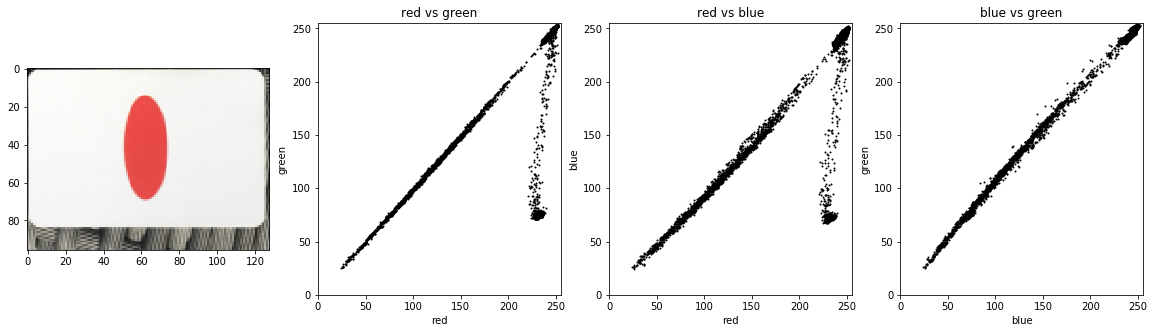

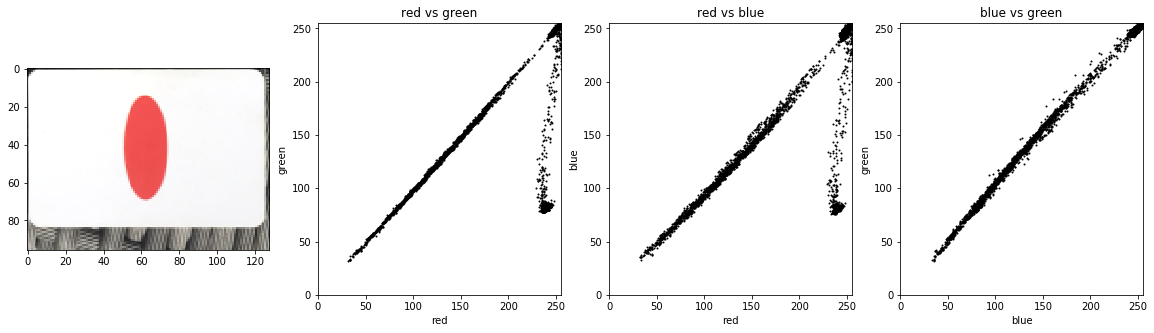

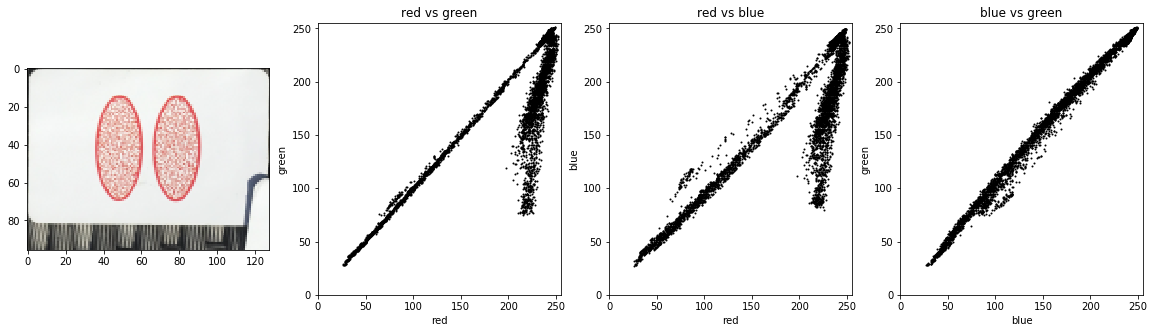

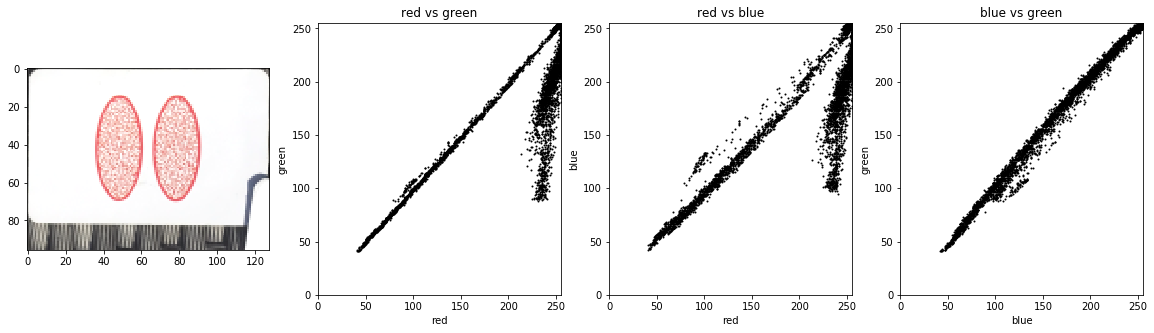

In [949]:
for card_id in np.arange(5):
    try:
        dataset = "test"
        img = get_image(dataset_path, dataset, card_id)
        #img_reduced, centroids = reduce_with_clusters(img, n_clusters=10)
        img_corrected = correct_color2(img)
        plot_scatter(img)
        plot_scatter(img_corrected)
    except:
        pass
plt.show()

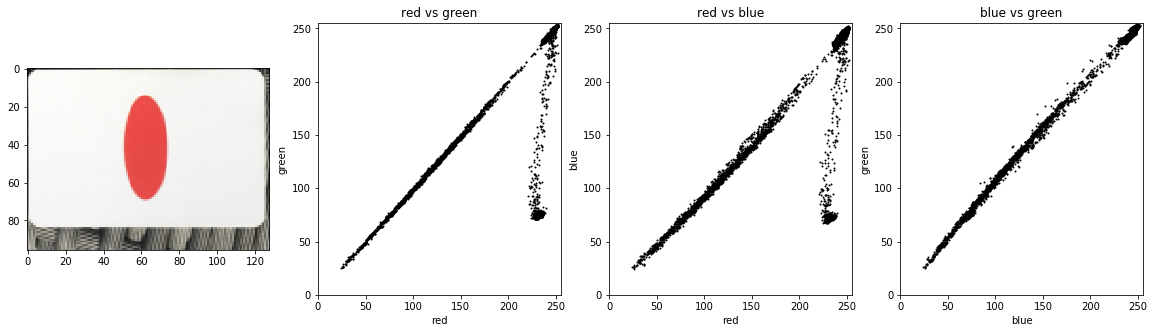

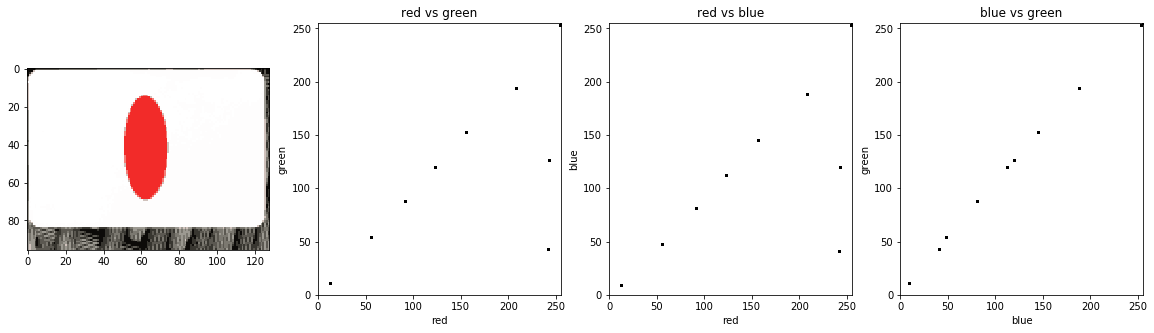

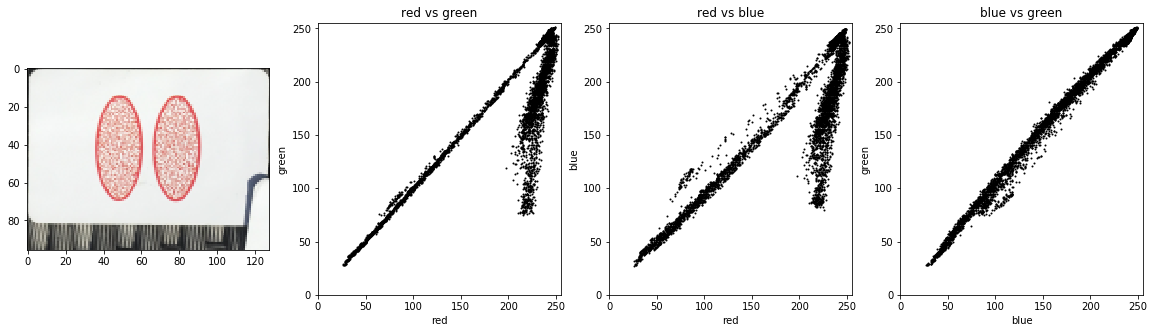

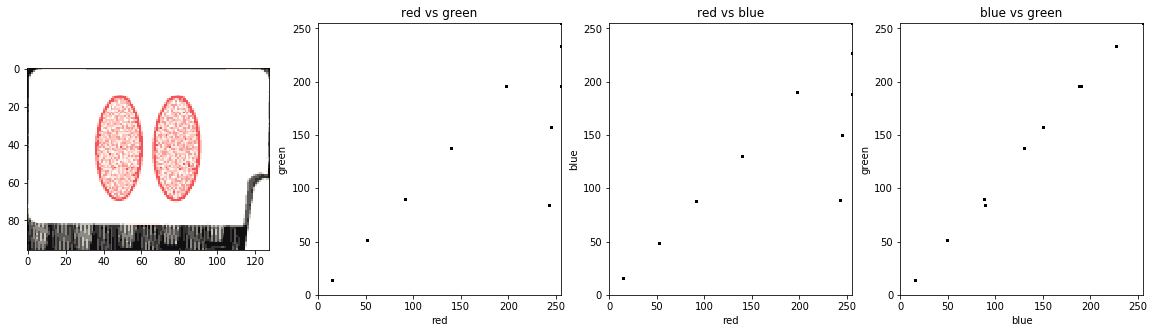

In [924]:
for card_id in np.arange(5):
    try:
        dataset = "test"
        img = get_image(dataset_path, dataset, card_id)
        #img_reduced, centroids = reduce_with_clusters(img, n_clusters=10)
        img_corrected = correct_color(img)
        plot_scatter(img)
        plot_scatter(img_corrected)
    except:
        pass